<a href="https://colab.research.google.com/github/0jipy/192kbps_colab_JIPY/blob/main/Ch06_CIFAR10_VGG16_Transfer_Learning_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIFAR10 Transfer Learning based Classifier

    - 기존 CNN모델 65%보다 얼마냐 항샹되는가
    - 첫 TL 모델.
This notebook outlines the steps to build a classifier to leverage concepts of Transfer Learning by utilizing a pretrained Deep-CNN. Particularly in this case based on VGG16

In [1]:
# Pandas and Numpy for data structures and util fucntions
import scipy as sp
import numpy as np
import pandas as pd
from numpy.random import rand
pd.options.display.max_colwidth = 600

# Scikit Imports
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.model_selection import train_test_split

import cnn_utils as utils
from model_evaluation_utils import get_metrics

# Matplot Imports
import matplotlib.pyplot as plt
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}

plt.rcParams.update(params)
%matplotlib inline

# pandas display data frames as tables
from IPython.display import display, HTML

import warnings
warnings.filterwarnings('ignore')

In [2]:
import tensorflow.python.keras.engine
# 아랫줄 Model 에러로 위코드로 수정. 뭐가 맞는걸까?
# engine 모듈 어디서 사용했는지 기억이...??

In [3]:
import tensorflow as tf
from keras import callbacks
from keras import optimizers
from keras.datasets import cifar10
# 수정중
# from tensorflow.keras
# from keras.engine import Model
from keras.applications import vgg16 as vgg
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils

## # Load and Prepare DataSet

In [4]:
BATCH_SIZE = 32
EPOCHS = 40
NUM_CLASSES = 10
LEARNING_RATE = 1e-4
MOMENTUM = 0.9

In [5]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170508288/170498071 [==============================] - 4s 0us/step


In [6]:
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train, 
                                                  test_size=0.15, 
                                                  stratify=np.array(y_train), 
                                                  random_state=42)

In [7]:
Y_train = np_utils.to_categorical(y_train, NUM_CLASSES)
Y_val = np_utils.to_categorical(y_val, NUM_CLASSES)
Y_test = np_utils.to_categorical(y_test, NUM_CLASSES)

### Preprocessing
Since we are about to use VGG16 as a feature extractor, the minimum size of an image it takes is 48x48. We utilize `scipy to resize images to required dimensions

In [8]:
# 수정전
# X_train = np.array([sp.misc.imresize(x,(48, 48)) for x in X_train])
# X_val = np.array([sp.misc.imresize(x,(48, 48)) for x in X_val])
# X_test = np.array([sp.misc.imresize(x,(48, 48)) for x in X_test])

# 수정후 
from skimage.transform import resize
X_train = np.array([resize(x,(48, 48)) for x in X_train])
X_val = np.array([resize(x,(48, 48)) for x in X_val])
X_test = np.array([resize(x,(48, 48)) for x in X_test])

## # Prepare the Model
- Load VGG16 without the top classification layer
- Prepare a custom classifier
- Stack both models on top of each other


In [9]:
base_model = vgg.VGG16(weights='imagenet', 
                       include_top=False, 
                       input_shape=(48, 48, 3))

58900480/58889256 [==============================] - 1s 0us/step


In [10]:
# Extract the last layer from third block of vgg16 model
last = base_model.get_layer('block3_pool').output

In [19]:
from keras import engine
tf.keras.Model()

In [12]:
# Add classification layers on top of it
x = GlobalAveragePooling2D()(last)
x= BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.6)(x)
pred = Dense(NUM_CLASSES, activation='softmax')(x)
model = tf.keras.Model(base_model.input, pred)

# Q. 질문. 에러 수정 못함. tf.keras.Model 은 된다 근데 위에 import 는
# 문구가 없어 Since our objective is to only train the custom classifier, we freeze the layers of VGG16

In [13]:
for layer in base_model.layers:
     layer.trainable = False

In [15]:
# Adam() 이런식으로 옵티마이져 사용 어떻게 해? error로 러닝레이트 옵션 못줬어.
model.compile(loss='binary_crossentropy',
              optimizer='adam', #러닝레이트 설정은 어케?
            #   optimizer=optimizers.Adam(lr=LEARNING_RATE),
              metrics=['accuracy'])

In [16]:
model.summary()
# 서머리의 파람은 예제와 같다. layer 동결여부는 어떻게 확인해야?

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

## # Data Augmentation
To help model generalize and overcome the limitations of a small dataset, we prepare augmented datasets using keras utilities


In [17]:
# prepare data augmentation configuration
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    horizontal_flip=False)

In [18]:
train_datagen.fit(X_train)
train_generator = train_datagen.flow(X_train,
                                     Y_train, 
                                     batch_size=BATCH_SIZE)

In [19]:
val_datagen = ImageDataGenerator(rescale=1. / 255,
    horizontal_flip=False)

val_datagen.fit(X_val)
val_generator = val_datagen.flow(X_val,
                                 Y_val,
                                 batch_size=BATCH_SIZE)

## # Train the Model

In [20]:
# 4분 실행에 6번째 에포크. 시간 고려해줘야 할듯. 기존 CNN모델 65%보다 향상된 결과 보여야.
train_steps_per_epoch = X_train.shape[0] // BATCH_SIZE
val_steps_per_epoch = X_val.shape[0] // BATCH_SIZE

history = model.fit_generator(train_generator,
                              steps_per_epoch=train_steps_per_epoch,
                              validation_data=val_generator,
                              validation_steps=val_steps_per_epoch,
                              epochs=EPOCHS,
                              verbose=1)

Epoch 1/40
1328/1328 [==============================] - 46s 26ms/step - loss: 0.2380 - accuracy: 0.4628 - val_loss: 0.1905 - val_accuracy: 0.5749
Epoch 2/40
1328/1328 [==============================] - 30s 23ms/step - loss: 0.1986 - accuracy: 0.5644 - val_loss: 0.1758 - val_accuracy: 0.6079
Epoch 3/40
1328/1328 [==============================] - 33s 25ms/step - loss: 0.1853 - accuracy: 0.5951 - val_loss: 0.1668 - val_accuracy: 0.6337
Epoch 4/40
1328/1328 [==============================] - 32s 24ms/step - loss: 0.1773 - accuracy: 0.6185 - val_loss: 0.1624 - val_accuracy: 0.6469
Epoch 5/40
1328/1328 [==============================] - 33s 25ms/step - loss: 0.1712 - accuracy: 0.6317 - val_loss: 0.1616 - val_accuracy: 0.6466
Epoch 6/40
1328/1328 [==============================] - 33s 25ms/step - loss: 0.1662 - accuracy: 0.6441 - val_loss: 0.1594 - val_accuracy: 0.6480
Epoch 7/40
1328/1328 [==============================] - 30s 22ms/step - loss: 0.1620 - accuracy: 0.6562 - val_loss: 0.1571 -

## # Analyze Model Performance

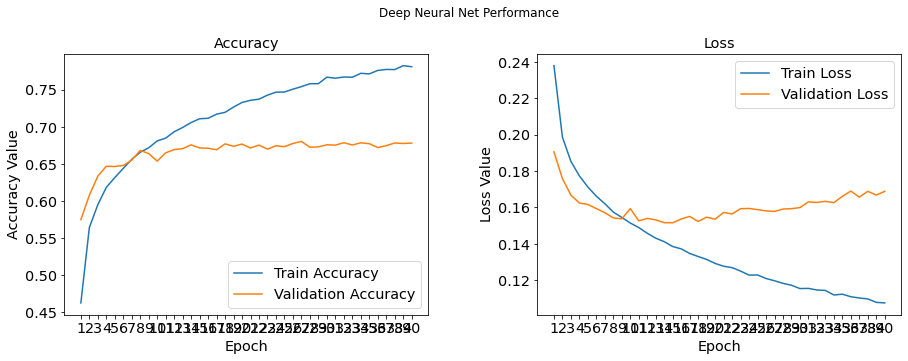

In [22]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
t = f.suptitle('Deep Neural Net Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epochs = list(range(1,EPOCHS+1))
ax1.plot(epochs, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(epochs)
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epochs, history.history['loss'], label='Train Loss')
ax2.plot(epochs, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(epochs)
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [23]:
predictions = model.predict(X_test/255.)

In [24]:
test_labels = list(y_test.squeeze())
predictions = list(predictions.argmax(axis=1))

In [25]:
get_metrics(true_labels=y_test, 
                predicted_labels=predictions)

Accuracy: 0.6815
Precision: 0.6898
Recall: 0.6815
F1 Score: 0.6838


## # Visualize Predictions

In [26]:
label_dict = {0:'airplane',
             1:'automobile',
             2:'bird',
             3:'cat',
             4:'deer',
             5:'dog',
             6:'frog',
             7:'horse',
             8:'ship',
             9:'truck'}

RuntimeError: ignored

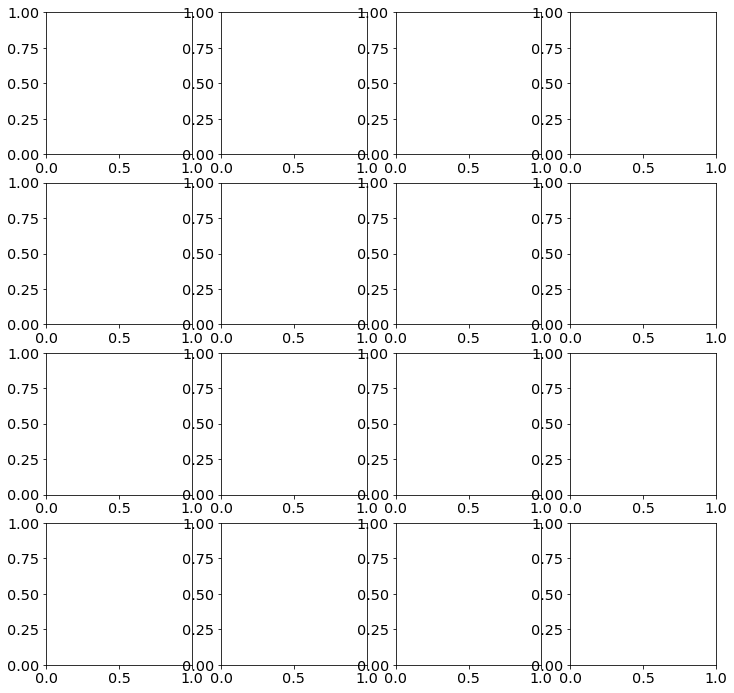

In [27]:
utils.plot_predictions(model=model,dataset=X_test/255.,
                       dataset_labels=Y_test,
                       label_dict=label_dict,
                       batch_size=16,
                       grid_height=4,
                       grid_width=4)